In [1]:
import numpy as np
import sys
sys.path.insert(0, '../..') #This line adds '../..' to the path so we can import the net_framework python file
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import networkx as nx
import scipy.signal as sp
import random
import pickle
import tensorflow as tf
from tensorflow import keras

In [79]:
num_nodes = 128
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = .01
q = .5
num_inputs = 1

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1.2/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i,i] = 0
    connectivity_matrix[i,i] = 0
weight_matrix = tf.Variable(weight_matrix)
connectivity_matrix = tf.constant(connectivity_matrix)

noise_weights = 1 * np.ones(num_nodes)
bias_weights = np.random.normal(0, 1/np.sqrt(num_inputs), num_nodes)
input_weights = np.random.normal(0, 1/np.sqrt(num_inputs), num_nodes)

input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)))

def rule_input(time):
    #No input for now
    return 0
    
def bias(time):
    return 1
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)


input_funcs = [bias, noise, rule_input]

init_activations = tf.constant(np.zeros((num_nodes, 1)))
output_weight_matrix = tf.constant(np.random.uniform(0, 1/np.sqrt(num_nodes), (1, num_nodes)))
        
network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)

Simulating Network Output

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1505.39it/s]


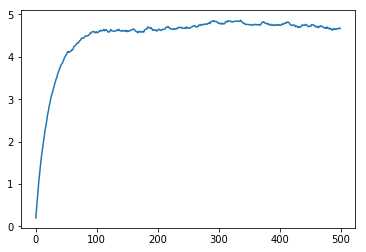

In [80]:
time = 5000 #ms
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.show()

First, training the network on a constant input = .2/output = .8 with noise

In [81]:
num_iters = 250
time = 5000 #ms

def rule_input(time):
    #running for 5 seconds = 5000ms, input =.2
    return .2 + np.random.normal(0, .05)
def target_func(time):
    #running for 5 seconds = 5000ms, out = .8.
    #Reverse of rule_input
    return .8

targets = network.convert(time, [target_func])
input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

weight_history, losses = network.train(num_iters, targets, time, num_trials = 1, inputs = inputs,
              input_weight_matrix = input_weight_matrix, learning_rate = .001)

  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

The loss is: tf.Tensor(9.837935, shape=(), dtype=float32) at iteration 0


 10%|████████                                                                         | 25/250 [00:15<02:06,  1.78it/s]

The loss is: tf.Tensor(0.7997309, shape=(), dtype=float32) at iteration 25


 20%|████████████████▏                                                                | 50/250 [00:29<01:51,  1.79it/s]

The loss is: tf.Tensor(0.049658626, shape=(), dtype=float32) at iteration 50


 30%|████████████████████████▎                                                        | 75/250 [00:43<01:36,  1.82it/s]

The loss is: tf.Tensor(0.00020422957, shape=(), dtype=float32) at iteration 75


 40%|████████████████████████████████                                                | 100/250 [00:57<01:23,  1.79it/s]

The loss is: tf.Tensor(0.00016490261, shape=(), dtype=float32) at iteration 100


 50%|████████████████████████████████████████                                        | 125/250 [01:12<01:13,  1.71it/s]

The loss is: tf.Tensor(0.00021765042, shape=(), dtype=float32) at iteration 125


 60%|████████████████████████████████████████████████                                | 150/250 [01:26<00:55,  1.82it/s]

The loss is: tf.Tensor(0.0002058349, shape=(), dtype=float32) at iteration 150


 70%|████████████████████████████████████████████████████████                        | 175/250 [01:41<00:44,  1.68it/s]

The loss is: tf.Tensor(0.00024747584, shape=(), dtype=float32) at iteration 175


 80%|████████████████████████████████████████████████████████████████                | 200/250 [01:56<00:28,  1.74it/s]

The loss is: tf.Tensor(0.00022944195, shape=(), dtype=float32) at iteration 200


 90%|████████████████████████████████████████████████████████████████████████        | 225/250 [02:11<00:14,  1.73it/s]

The loss is: tf.Tensor(0.00028723426, shape=(), dtype=float32) at iteration 225


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [02:25<00:00,  1.81it/s]


ValueError: too many values to unpack (expected 2)

Next, training the network on constant input=.8/output=.2 with noise

In [84]:
num_iters = 250
time = 5000 #ms
def rule_input(time):
    #running for 5 seconds = 5000ms, input =.2
    return .8 + np.random.normal(0, .05)
def target_func(time):
    #running for 5 seconds = 5000ms, out = .8.
    #Reverse of rule_input
    return .2

targets = network.convert(time, [target_func])
input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

weight_history_2, losses_2 = network.train(num_iters, targets, time, num_trials = 1, inputs = inputs,
              input_weight_matrix = input_weight_matrix, learning_rate = .001)

  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

The loss is: tf.Tensor(1.3487381, shape=(), dtype=float32) at iteration 0


 10%|████████                                                                         | 25/250 [00:15<02:23,  1.56it/s]

The loss is: tf.Tensor(0.36040673, shape=(), dtype=float32) at iteration 25


 20%|████████████████▏                                                                | 50/250 [00:34<02:09,  1.55it/s]

The loss is: tf.Tensor(0.13114315, shape=(), dtype=float32) at iteration 50


 30%|████████████████████████▎                                                        | 75/250 [00:49<01:38,  1.78it/s]

The loss is: tf.Tensor(0.03316389, shape=(), dtype=float32) at iteration 75


 40%|████████████████████████████████                                                | 100/250 [01:05<01:28,  1.69it/s]

The loss is: tf.Tensor(0.00599914, shape=(), dtype=float32) at iteration 100


 50%|████████████████████████████████████████                                        | 125/250 [01:21<01:14,  1.68it/s]

The loss is: tf.Tensor(5.2517007e-05, shape=(), dtype=float32) at iteration 125


 52%|█████████████████████████████████████████▉                                      | 131/250 [01:25<01:14,  1.60it/s]

KeyboardInterrupt: 

Next, training the network on the transition from low to high and the transition from high to low

In [ ]:
num_iters = 1000
time = 10000 #ms
targets = network.convert(time, [target_func])
#regularizer = tf.keras.regularizers.L1(l1 = 0.0001)
weight_history_3, losses_3 = network.train(num_iters, targets, time, num_trials = 1, inputs = inputs,
              input_weight_matrix = input_weight_matrix, learning_rate = .0005)#, regularizer = regularizer)

Now, simulating network activity to ensure that it works.

In [87]:
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms, input =.2
    return .8 + np.random.normal(0, .05)
def target_func(time):
    #running for 5 seconds = 5000ms, out = .8.
    #Reverse of rule_input
    return .2

targets = network.convert(time, [target_func])
input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1542.57it/s]


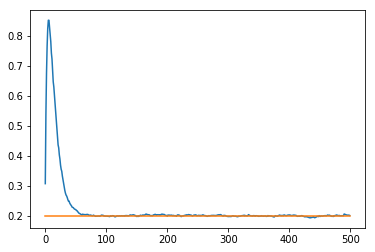

In [88]:

outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [ ]:
activations = np.asarray(activations)
for i in range(4):
    fig, ax = plt.subplots()
    plt.plot(range(len(activations[:,i])), activations[:,i])
    plt.show()